# Kinetic energy analysis

In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import jcpy.signal as jsig
from matplotlib.dates import DateFormatter
from munch import munchify
import utils
import os
from scipy import stats
from scipy.signal import spectrogram
import xskillscore as xs
import gsw

def interval_to_mid(intervals):
    return np.array([v.mid for v in intervals])

SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Load datasets.

In [2]:
AS = xr.open_dataset("../data/ABLE_sentinel_mooring_2018.nc")
AS.coords["depth_adcp"] = (AS.distance.dims, (AS.depth_ADCP.mean().values - AS.distance).data, dict(long_name="depth"))
DD = xr.open_dataset("../data/downstream_deep_mooring_2018.nc")

SMB = munchify(utils.loadmat(os.path.expanduser("../data/runoff_extended_2018.mat")))
SMB = xr.Dataset(dict(low_scen=(['time'], SMB.low_scen), middle_scen=(['time'], SMB.middle_scen), high_scen=(['time'], SMB.high_scen)), dict(time=(['time'], utils.datenum_to_datetime(SMB.time))))

Define some useful functions for estimating cutoff frequency and time for moving averages. 

In [3]:
def Fc(ts, N):
    """
    Parameters 
    ----------
        ts : float
            Sampling period [s]
        N : float
            Points in window.
            
            
    Notes
    -----
    -3dB frequency response of moving average: https://dsp.stackexchange.com/questions/9966/what-is-the-cut-off-frequency-of-a-moving-average-filter
        
    """
    return 0.442946470689452340308369 / np.sqrt(N**2 - 1) / ts

def Tcmin(ts, N):
    """
    Parameters 
    ----------
        ts : float
            Sampling period [s]
        N : float
            Points in window.
        
    """
    return 1 / Fc(ts, N) / 60


def NFc(Tc, ts):
    """
    Parameters 
    ----------
        ts : float
            Sampling period in units of time e.g. seconds.
        Tc : float
            Cut off period. Same units as ts.
        
    """
    a = 0.442946470689452340308369
    return round((1 + (a**2 * Tc**2)/ts**2)**0.5)

# MN - near mooring

Define parameters for moving average filtering, depth cut offs, minimum good data threshold and pitch/roll variance thresholds for iceberg detection. 

In [4]:
dt = (AS.time[1] - AS.time[0]).data.astype("timedelta64[s]").astype(float)
frac_min = 0.9
nhigh = NFc(60*5, int(dt))
nlow = NFc(60*30, int(dt))
nminhigh = int(frac_min*nhigh)
nminlow = int(frac_min*nlow)
npitch = 7
max_pitch_var = 0.05
dmin = 20
dmax = 120
nhours = 1 # Time binning
min_good = 0.9 # Depth fraction allowed

print(f"High cut off = {Tcmin(10, nhigh):1.2f} min")
print(f"Low cut off = {Tcmin(10, nlow):1.2f} min")
print(f"High cut off = {1440/Tcmin(10, nhigh):1.2f} cpd")
print(f"Low cut off = {1440/Tcmin(10, nlow):1.2f} cpd")
print(f"n High = {nhigh}")
print(f"n Low = {nlow}")

pitch_var = AS.pitch.rolling(time=npitch, center=True).var()

# Remove iceberg events
bad = pitch_var > max_pitch_var
contig = jsig.contiguous_regions(bad)
idx0 = contig[:, 0]
idx1 = contig[:, 1]
# go 2 min earlier
idx0 -= int(60*2/dt)
# go 20 min later
idx1 = idx0 + int(60*20/dt)

# Make mask
for i in range(idx0.size):
    bad[idx0[i]:idx1[i]] = True
    
good = ~bad

High cut off = 4.88 min
Low cut off = 30.10 min
High cut off = 295.26 cpd
Low cut off = 47.84 cpd
n High = 13
n Low = 80


In [5]:
AS_ = AS.isel(distance=(AS.depth > dmin) & (AS.depth < dmax))

ul = AS_.u.where(good).rolling(time=nlow, min_periods=nminlow, center=True).mean()
uh = AS_.u.where(good).rolling(time=nhigh, min_periods=nminhigh, center=True).mean()
ub = uh - ul
wl = AS_.vv.where(good).rolling(time=nlow, min_periods=nminlow, center=True).mean()
wh = AS_.vv.where(good).rolling(time=nhigh, min_periods=nminhigh, center=True).mean()
wb = wh - wl
vl = AS_.v.where(good).rolling(time=nlow, min_periods=nminlow, center=True).mean()
vh = AS_.v.where(good).rolling(time=nhigh, min_periods=nminhigh, center=True).mean()
vb = vh - vl

KEl = ul**2 + vl**2
KEb = ub**2 + vb**2 + wb**2

In [6]:
wb.to_netcdf("../data/MN_band_pass_w.nc")

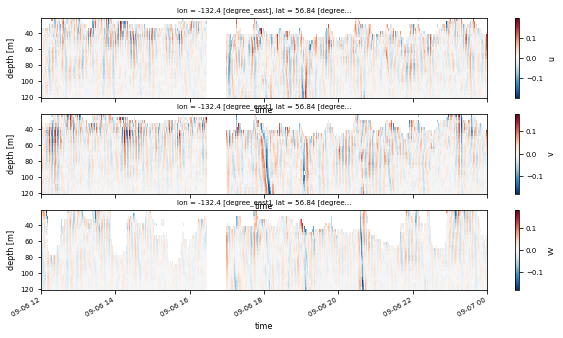

In [7]:
# time1 = np.datetime64("2018-09-06T15:00")
# tslice = slice(time1, time1 + np.timedelta64(3600*3, 's'))

time1 = np.datetime64("2018-09-06T12:00")
tslice = slice(time1, time1 + np.timedelta64(3600*12, 's'))

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 5))

ub.sel(time=tslice).plot(ax=axs[0], x="time", y="depth", yincrease=False)
vb.sel(time=tslice).plot(ax=axs[1], x="time", y="depth", yincrease=False)
wb.sel(time=tslice).plot(ax=axs[2], x="time", y="depth", yincrease=False)

Depth average kinetic energy

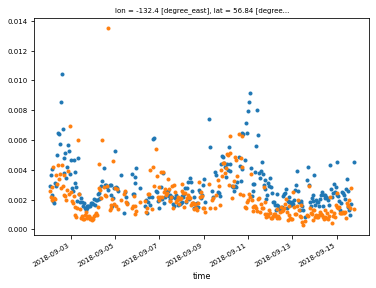

In [8]:
nall = KEl.isnull() | KEb.isnull()

nmax = nall.distance.size
ngood = nmax - nall.sum("distance")
frac_good = ngood/nmax
good = (frac_good > min_good)
# dz = (AS.distance[1] - AS.distance[0]).data

KEl_ave = (KEl.sum("distance")/ngood).where(good)
KEb_ave = (KEb.sum("distance")/ngood).where(good)

KEl_re = KEl_ave.resample(time=f"{nhours}H", skipna=True).mean()
KEb_re = KEb_ave.resample(time=f"{nhours}H", skipna=True).mean()

KEl_re.plot(marker=".", linestyle="")
KEb_re.plot(marker=".", linestyle="")

What is velocity like during those odd spikes?

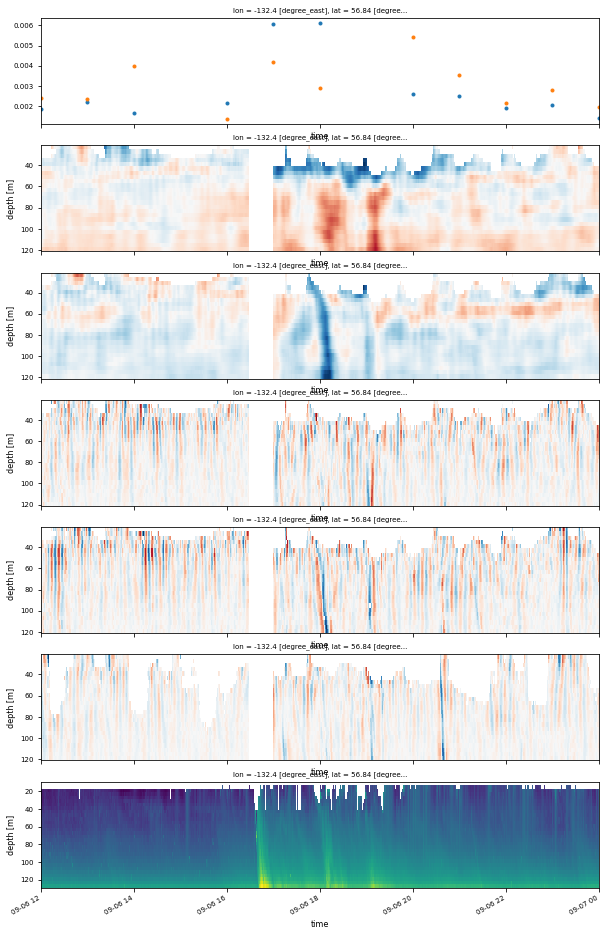

In [9]:
# time1 = np.datetime64("2018-09-06T15:00")
# tslice = slice(time1, time1 + np.timedelta64(3600*3, 's'))

time1 = np.datetime64("2018-09-06T12:00")
tslice = slice(time1, time1 + np.timedelta64(3600*12, 's'))

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 16))

KEl_re.sel(time=tslice).plot(marker=".", linestyle="", ax=axs[0])
KEb_re.sel(time=tslice).plot(marker=".", linestyle="", ax=axs[0])
ul.sel(time=tslice).plot(ax=axs[1], x="time", y="depth", yincrease=False, add_colorbar=False)
vl.sel(time=tslice).plot(ax=axs[2], x="time", y="depth", yincrease=False, add_colorbar=False)
ub.sel(time=tslice).plot(ax=axs[3], x="time", y="depth", yincrease=False, add_colorbar=False)
vb.sel(time=tslice).plot(ax=axs[4], x="time", y="depth", yincrease=False, add_colorbar=False)
wb.sel(time=tslice).plot(ax=axs[5], x="time", y="depth", yincrease=False, add_colorbar=False)
AS.a2.sel(time=tslice).plot(ax=axs[6], x="time", y="depth", yincrease=False, add_colorbar=False)

A qualitative look at discharge and energy. 

(array([189.83050847, 400.        , 254.23728814,  74.57627119,
         47.45762712,  13.55932203,  16.94915254,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   3.38983051,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019]),
 [<matplotlib.patches.Polygon at 0x1215ea320>])

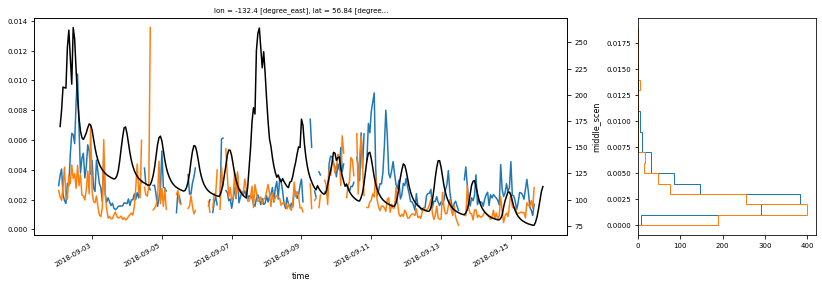

In [10]:
bins = np.arange(0, 0.02, 0.001)

fig, axs = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw=dict(width_ratios=[3, 1]))

KEl_re.plot(ax=axs[0])
KEb_re.plot(ax=axs[0])

axt = axs[0].twinx()
SMB.middle_scen.sel(time=slice(KEl_re.time[0], KEl_re.time[-1])).plot(ax=axt, color="k")

axs[1].hist(KEl_re, bins, density=True, orientation="horizontal", histtype="step")
axs[1].hist(KEb_re, bins, density=True, orientation="horizontal", histtype="step")

Figure for paper.

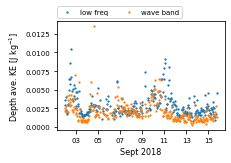

In [11]:
bins = np.arange(0, 0.02, 0.001)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.plot(KEl_re.time, KEl_re, "C0.", ms=2.5, lw=0.5, label="low freq")
ax.plot(KEb_re.time, KEb_re, "C1.", ms=2.5, lw=0.5, label="wave band")

ax.legend(ncol=2, loc=(0, 1.03), fontsize=7)
ax.set_ylabel("Depth ave. KE [J kg$^{-1}$]")

date_form = DateFormatter("%d")
ax.xaxis.set_major_formatter(date_form)
ax.set_xlabel("Sept 2018")

fig.savefig("../figures/short_term_KE.pdf", dpi=300, bbox_inches="tight", pad_inches=0.01)
fig.savefig("../figures/short_term_KE.png", dpi=300, bbox_inches="tight", pad_inches=0.01)


# with emperical distribution function below

# bins = np.arange(0, 0.02, 0.001)

# fig, axs = plt.subplots(1, 2, figsize=(3, 2), gridspec_kw=dict(width_ratios=[5, 1], wspace=0))
# axs[1].set_yticks([])
# axs[1].set_xticks([])

# axs[0].plot(KEl_re.time, KEl_re, "C9.", lw=2, label="low freq")
# axs[0].plot(KEb_re.time, KEb_re, "C0.", lw=2, label="wave band")

# axs[0].legend(ncol=2, loc=(0, 1.03), fontsize=7)
# axs[0].set_ylabel("Depth ave. KE\n[J kg$^{-1}$]")

# date_form = DateFormatter("%d")
# axs[0].xaxis.set_major_formatter(date_form)
# axs[0].set_xlabel("Sept 2018")

# _ = axs[1].hist(KEl_re, bins, density=True, orientation="horizontal", histtype="step",  color="C9", lw=2)
# _ = axs[1].hist(KEb_re, bins, density=True, orientation="horizontal", histtype="step",  color="C0", lw=2)

# fig.savefig("../figures/short_term_KE.pdf", dpi=300, bbox_inches="tight", pad_inches=0.01)
# fig.savefig("../figures/short_term_KE.png", dpi=300, bbox_inches="tight", pad_inches=0.01)

## Error analysis

Error on the energy fraction.

KE low mean 2.89e-03 J kg-1
KE wave mean 2.06e-03 J kg-1
KE std mean 7.90e-05 J kg-1
KE frac mean 41.58%
KE frac std 0.94%
KE frac 95% error 1.87%


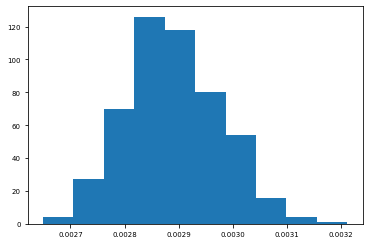

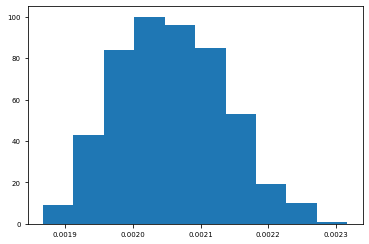

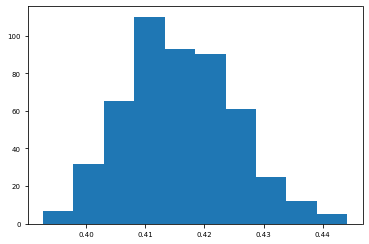

In [12]:
bootnum = 500
np.random.seed(482990)

good = np.isfinite(KEl_re) & np.isfinite(KEb_re) #& (SMBb.middle_scen > 10)

KElr = KEl_re[good].data
KEbr = KEb_re[good].data

ndat = KEbr.size
idxs = np.arange(ndat)

KEl_mean = np.zeros((bootnum))
KEb_mean = np.zeros((bootnum))

for i in range(bootnum):
    idxs_ = np.random.choice(idxs, ndat)
    KEl_mean[i] = KElr[idxs_].mean()
    KEb_mean[i] = KEbr[idxs_].mean()
    
KE_frac = KEb_mean/(KEb_mean + KEl_mean)

fig, ax = plt.subplots()
_ = ax.hist(KEl_mean)

fig, ax = plt.subplots()
_ = ax.hist(KEb_mean)

fig, ax = plt.subplots()
_ = ax.hist(KE_frac)

print(f"KE low mean {KEl_mean.mean():.2e} J kg-1")
print(f"KE wave mean {KEb_mean.mean():.2e} J kg-1")
print(f"KE std mean {KEb_mean.std():.2e} J kg-1")
print(f"KE frac mean {KE_frac.mean():.2%}")
print(f"KE frac std {KE_frac.std():.2%}")
print(f"KE frac 95% error {2*KE_frac.std():.2%}")

Error on energy fraction for times when the plume is not over the mooring.

KE low mean 2.53e-03
KE wave mean 1.98e-03
KE wave std 8.51e-05
KE frac mean 43.90%
KE frac std 0.97%


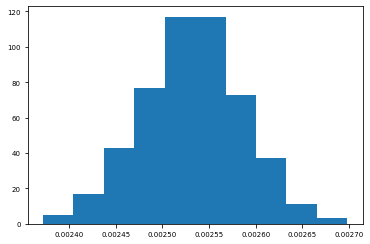

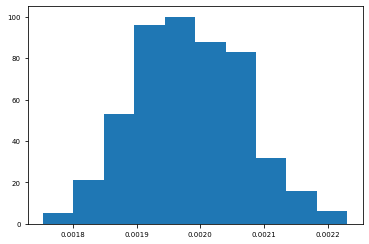

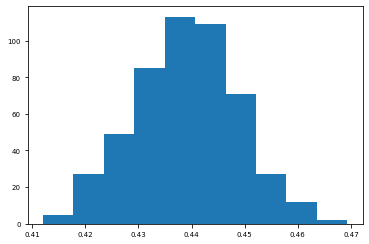

In [13]:
bootnum = 500
np.random.seed(482990)

good = np.isfinite(KEl_re) & np.isfinite(KEb_re) & (KEl_re < 0.005)

KElr = KEl_re[good].data
KEbr = KEb_re[good].data

ndat = KEbr.size
idxs = np.arange(ndat)

KEl_mean = np.zeros((bootnum))
KEb_mean = np.zeros((bootnum))

for i in range(bootnum):
    idxs_ = np.random.choice(idxs, ndat)
    KEl_mean[i] = KElr[idxs_].mean()
    KEb_mean[i] = KEbr[idxs_].mean()
    
KE_frac = KEb_mean/(KEb_mean + KEl_mean)

fig, ax = plt.subplots()
_ = ax.hist(KEl_mean)

fig, ax = plt.subplots()
_ = ax.hist(KEb_mean)

fig, ax = plt.subplots()
_ = ax.hist(KE_frac)

print(f"KE low mean {KEl_mean.mean():.2e}")
print(f"KE wave mean {KEb_mean.mean():.2e}")
print(f"KE wave std {KEb_mean.std():.2e}")
print(f"KE frac mean {KE_frac.mean():.2%}")
print(f"KE frac std {KE_frac.std():.2%}")

## Mean speed of waves and impact on melt rates

In [14]:
rand_seed = 9885333
nsamples = 5000
nit = 100

spdnl = np.sqrt(vl**2)
spdl = np.sqrt(ul**2 + vl**2)
spdntot = np.sqrt((vb + vl)**2 + wb**2)
spdtot = np.sqrt((ub + ul)**2 + (vb + vl)**2 + wb**2)
spdlm = spdl.mean("time")
spdtotm = spdtot.mean("time")
spdnlm = spdnl.mean("time")
spdntotm = spdntot.mean("time")

np.random.seed(rand_seed)
spdl_rs = xs.resample_iterations_idx(spdl, nit, dim="time", dim_max=nsamples).mean("time")
np.random.seed(rand_seed)
spdtot_rs = xs.resample_iterations_idx(spdtot, nit, dim="time", dim_max=nsamples).mean("time")
np.random.seed(rand_seed)
spdnl_rs = xs.resample_iterations_idx(spdnl, nit, dim="time", dim_max=nsamples).mean("time")
np.random.seed(rand_seed)
spdntot_rs = xs.resample_iterations_idx(spdntot, nit, dim="time", dim_max=nsamples).mean("time")

pctl = np.percentile(spdl_rs, [5, 95], axis=1)
pcttot = np.percentile(spdtot_rs, [5, 95], axis=1)
pct_ratio = np.percentile((100*(spdtot_rs/spdl_rs - 1)), [5, 95], axis=1) 

pctnl = np.percentile(spdnl_rs, [5, 95], axis=1)
pctntot = np.percentile(spdntot_rs, [5, 95], axis=1)
pctn_ratio = np.percentile((100*(spdntot_rs/spdnl_rs - 1)), [5, 95], axis=1) 

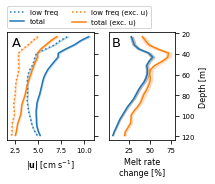

In [15]:
lfls = ":"

fig, axs = plt.subplots(1, 2, figsize=(3, 2), gridspec_kw=dict(width_ratios=[2, 1.5]))
for ax in axs:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.invert_yaxis()

# North and East
col = "C0"
axs[0].plot(spdlm*100, spdl.depth, col, ls=lfls, label="low freq")
axs[0].fill_betweenx(spdl.depth, pctl[0, :]*100, pctl[1, :]*100, color=col, alpha=0.2)
axs[0].plot(spdtotm*100, spdl.depth, col, label="total")
axs[0].fill_betweenx(spdl.depth, pcttot[0, :]*100, pcttot[1, :]*100, color=col, alpha=0.2)
change = (spdtotm/spdlm - 1)*100
axs[1].plot(change, spdtot.depth, col)
axs[1].fill_betweenx(spdl.depth, pct_ratio[0, :], pct_ratio[1, :], color="k", alpha=0.2)

# North
col = "C1"
axs[0].plot(spdnlm*100, spdnl.depth, col, ls=lfls, label="low freq (exc. u)")
axs[0].fill_betweenx(spdnl.depth, pctnl[0, :]*100, pctnl[1, :]*100, color=col, alpha=0.2)
axs[0].plot(spdntotm*100, spdnl.depth, col, label="total (exc. u)")
axs[0].fill_betweenx(spdnl.depth, pctntot[0, :]*100, pctntot[1, :]*100, color=col, alpha=0.2)
changen = (spdntotm/spdnlm - 1)*100
axs[1].plot(changen, spdntot.depth, col)
axs[1].fill_betweenx(spdnl.depth, pctn_ratio[0, :], pctn_ratio[1, :], color=col, alpha=0.2)

axs[0].set_yticklabels([])
axs[0].set_xlabel(r"$|\bf{u}|$ [cm s$^{-1}$]")#, fontsize=fontsize)
axs[1].set_xlabel("Melt rate\nchange [%]")#, fontsize=fontsize)
axs[1].set_ylabel("Depth [m]")#, fontsize=fontsize)

axs[0].legend(ncol=2, loc=(-0.0, 1.03), fontsize=7)

axs[0].text(0.1, 0.9, "A", fontsize=13, ha='center', va='center', transform=axs[0].transAxes)
axs[1].text(0.1, 0.9, "B", fontsize=13, ha='center', va='center', transform=axs[1].transAxes)

ax.text
fig.savefig("../figures/melting2.pdf", dpi=300, bbox_inches="tight", pad_inches=0.01)
fig.savefig("../figures/melting2.png", dpi=300, bbox_inches="tight", pad_inches=0.01)

In [16]:
print(f"Max change (north only): {changen.max().data}")
print(f"Max change: {change.max().data}")

Max change (north only): 71.8876724243164
Max change: 53.32306671142578


Figure with buoyancy frequency. First, load data.

In [17]:
dd = xr.open_dataset("../data/downstream_deep_mooring_2018.nc")
# ctd = xr.open_dataset("../data/combo_sep_2018.nc")
pfl = np.genfromtxt('../data/sep_2018_mean_TS_profile.csv', delimiter=',', skip_header=1)

cdepth = pfl[:, 0]
cSP = pfl[:, 1]
ct = pfl[:, 2]

cp = gsw.p_from_z(-cdepth, dd.lat.values)
cSA = gsw.SA_from_SP(cSP, cdepth, dd.lon.values, dd.lat.values)
cCT = gsw.CT_from_t(cSA, ct, cp)
csig0 = gsw.pot_rho_t_exact(cSA, ct, cp, 0)
N2, p_mid = gsw.Nsquared(cSA, cCT, cp)
Ncpd = np.sqrt(N2)*86400/(np.pi*2)

Add panel to figure.

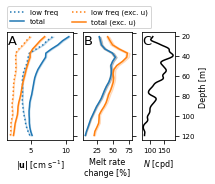

In [18]:
lfls = ":"

fig, axs = plt.subplots(1, 3, figsize=(3, 2), gridspec_kw=dict(width_ratios=[2, 1.5, 1]))

for ax in axs:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.invert_yaxis()

# North and East
col = "C0"
axs[0].plot(spdlm*100, spdl.depth, col, ls=lfls, label="low freq")
axs[0].fill_betweenx(spdl.depth, pctl[0, :]*100, pctl[1, :]*100, color=col, alpha=0.2)
axs[0].plot(spdtotm*100, spdl.depth, col, label="total")
axs[0].fill_betweenx(spdl.depth, pcttot[0, :]*100, pcttot[1, :]*100, color=col, alpha=0.2)
change = (spdtotm/spdlm - 1)*100
axs[1].plot(change, spdtot.depth, col)
axs[1].fill_betweenx(spdl.depth, pct_ratio[0, :], pct_ratio[1, :], color="k", alpha=0.2)

# North
col = "C1"
axs[0].plot(spdnlm*100, spdnl.depth, col, ls=lfls, label="low freq (exc. u)")
axs[0].fill_betweenx(spdnl.depth, pctnl[0, :]*100, pctnl[1, :]*100, color=col, alpha=0.2)
axs[0].plot(spdntotm*100, spdnl.depth, col, label="total (exc. u)")
axs[0].fill_betweenx(spdnl.depth, pctntot[0, :]*100, pctntot[1, :]*100, color=col, alpha=0.2)
changen = (spdntotm/spdnlm - 1)*100
axs[1].plot(changen, spdntot.depth, col)
axs[1].fill_betweenx(spdnl.depth, pctn_ratio[0, :], pctn_ratio[1, :], color=col, alpha=0.2)

# Stratification
use = (p_mid < 120) & (p_mid > 20)
axs[2].plot(Ncpd[use], p_mid[use], "k")

axs[0].set_yticklabels([])
axs[1].set_yticklabels([])
axs[0].set_xlabel(r"$|\bf{u}|$ [cm s$^{-1}$]")#, fontsize=fontsize)
axs[1].set_xlabel("Melt rate\nchange [%]")#, fontsize=fontsize)
axs[2].set_ylabel("Depth [m]")#, fontsize=fontsize)
axs[2].set_xlabel("$N$ [cpd]")

axs[0].legend(ncol=2, loc=(-0.0, 1.03), fontsize=7)

for i, lab in enumerate(["A", "B", "C"]):
    axs[i].annotate(lab, (5, 100), fontsize=13, ha='center', va='center', xycoords="axes points")

ax.text
fig.savefig("../figures/melting_strat.pdf", dpi=300, bbox_inches="tight", pad_inches=0.01)
fig.savefig("../figures/melting_strat.png", dpi=300, bbox_inches="tight", pad_inches=0.01)

## Correlations with discharge

Correlation between IW KE and discharge: 0.38511842430338505
Correlation between IW KE and LF KE: 0.7147299212148495
Correlation between LF KE and discharge: 0.507288381658117


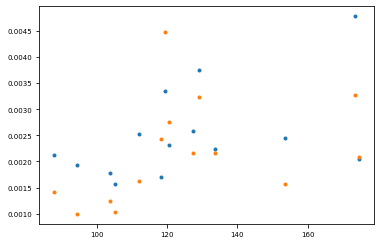

In [19]:
min_good_frac = 0.9
nhours = 24
nmin = 10
time_resample = f"{nhours}H"

dmin = 30
dmax = 100

KEl = ul**2 + vl**2
KEb = ub**2 + vb**2 + wb**2

KEl = KEl.isel(distance=(KEl.depth > dmin) & (KEl.depth < dmax))
KEb = KEb.isel(distance=(KEb.depth > dmin) & (KEb.depth < dmax))

nall = KEl.isnull() | KEb.isnull()
nmax = nall.distance.size
ngood = nmax - nall.sum("distance")
frac_good = ngood/nmax

good = (frac_good > min_good_frac)

KEl_ave = (KEl.sum("distance")/ngood).where(good)
KEb_ave = (KEb.sum("distance")/ngood).where(good)

KEl_re = KEl_ave.resample(time=time_resample, skipna=True).mean()
KEb_re = KEb_ave.resample(time=time_resample, skipna=True).mean()

# Scale the standard deviation by the sqrt of number of samples in each window to estimate the standard error on the mean
KEl_re_std = KEl_ave.resample(time=f"{nmin}Min", skipna=True).mean().resample(time=time_resample, skipna=True).std()/np.sqrt(60*nhours/nmin)
KEb_re_std = KEb_ave.resample(time=f"{nmin}Min", skipna=True).mean().resample(time=time_resample, skipna=True).std()/np.sqrt(60*nhours/nmin)

time_bins = np.hstack((KEb_re.time, KEb_re.time[-1] + np.timedelta64(nhours, "h"))) - np.timedelta64(30*nhours, "m")

SMBb = SMB.groupby_bins("time", time_bins).mean()

SMBb["time_bins"] = interval_to_mid(SMBb.time_bins.values).astype("datetime64[s]")
SMBb = SMBb.rename({"time_bins": "time"})

fig, ax = plt.subplots()
ax.plot(SMBb.middle_scen, KEl_re, '.')
ax.plot(SMBb.middle_scen, KEb_re, '.')

print(f"Correlation between IW KE and discharge: {xr.corr(SMBb.middle_scen, KEb_re).data}")
print(f"Correlation between IW KE and LF KE: {xr.corr(KEl_re, KEb_re).data}")
print(f"Correlation between LF KE and discharge: {xr.corr(KEl_re, SMBb.middle_scen).data}")

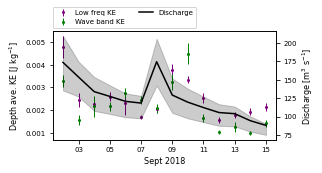

In [20]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(4, 2))
axt = ax.twinx()

axt.fill_between(SMBb.time, SMBb.low_scen, SMBb.high_scen, color="k", alpha=0.2)
ln1 = axt.plot(SMBb.time, SMBb.middle_scen, "k", label="Discharge")
# ln2 = axt.plot(KEl_re.time, KEl_re, '.', label="High freq KE")
ln2 = ax.errorbar(mdates.date2num(KEl_re.time), KEl_re, yerr=2*KEl_re_std, fmt=".", ms=4, color="purple", elinewidth=1,label="Low freq KE")
# ln3 = axt.plot(KEb_re.time, KEb_re, '.', label="High freq KE")
ln3 = ax.errorbar(mdates.date2num(KEb_re.time), KEb_re, yerr=2*KEb_re_std, fmt=".", ms=4, color="g", elinewidth=1,label="Wave band KE")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, ncol=2, loc=(0, 1.03), fontsize=7)

date_form = DateFormatter("%d")
ax.xaxis.set_major_formatter(date_form)
ax.set_xlabel("Sept 2018")

axt.set_ylabel("Discharge [m$^3$ s$^{-1}$]")
ax.set_ylabel("Depth ave. KE [J kg$^{-1}$]")

fig.savefig("../figures/short_term_KE_discharge.pdf", dpi=300, bbox_inches="tight", pad_inches=0.01)
fig.savefig("../figures/short_term_KE_discharge.png", dpi=300, bbox_inches="tight", pad_inches=0.01)

Correlation between discharge and wave energy.

R mean 0.40389840762123147
R std 0.2169582032552241
R^2 mean 0.21020478563870157
R^2 std 0.17625280203049543


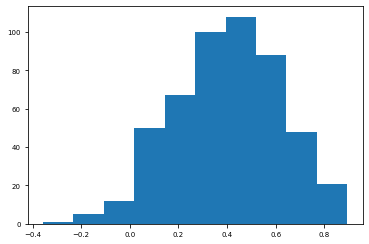

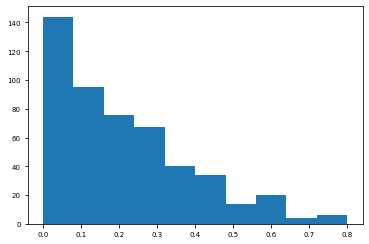

In [21]:
bootnum = 500
np.random.seed(56642)

good = np.isfinite(SMBb.middle_scen) & np.isfinite(KEb_re) #& (SMBb.middle_scen > 10)

SMBr = SMBb.middle_scen[good].data
KEr = KEb_re[good].data

ndat = KEr.size
idxs = np.arange(ndat)

rvals = np.zeros((bootnum))
pvals = np.zeros((bootnum))

for i in range(bootnum):
    idxs_ = np.random.choice(idxs, ndat)
    rvals[i], pvals[i] = stats.pearsonr(SMBr[idxs_], KEr[idxs_])

fig, ax = plt.subplots()
_ = ax.hist(rvals)

fig, ax = plt.subplots()
_ = ax.hist(rvals**2)

print(f"R mean {rvals.mean()}")
print(f"R std {rvals.std()}")
print(f"R^2 mean {(rvals**2).mean()}")
print(f"R^2 std {(rvals**2).std()}")

Correlation between low freq energy and wave energy.

R mean 0.7310004923184978
R std 0.11466713302896733
R^2 mean 0.547510271166969
R^2 std 0.14773370729434826


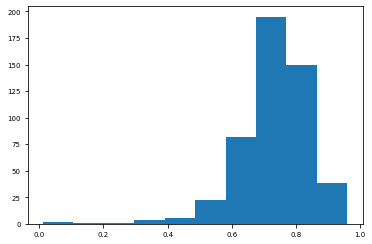

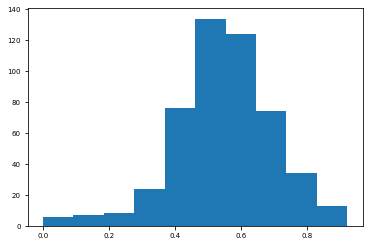

In [22]:
bootnum = 500
np.random.seed(56642)

good = np.isfinite(KEl_re) & np.isfinite(KEb_re) #& (SMBb.middle_scen > 10)

KElr = KEl_re[good].data
KEbr = KEb_re[good].data

ndat = KEbr.size
idxs = np.arange(ndat)

rvals = np.zeros((bootnum))
pvals = np.zeros((bootnum))

for i in range(bootnum):
    idxs_ = np.random.choice(idxs, ndat)
    rvals[i], pvals[i] = stats.pearsonr(KElr[idxs_], KEbr[idxs_])

fig, ax = plt.subplots()
_ = ax.hist(rvals)

fig, ax = plt.subplots()
_ = ax.hist(rvals**2)

print(f"R mean {rvals.mean()}")
print(f"R std {rvals.std()}")
print(f"R^2 mean {(rvals**2).mean()}")
print(f"R^2 std {(rvals**2).std()}")

Correlations between low freq KE and discharge

R mean 0.4613598468970248
R std 0.23979991099622122
R^2 mean 0.27035690564264175
R^2 std 0.21040610738847046


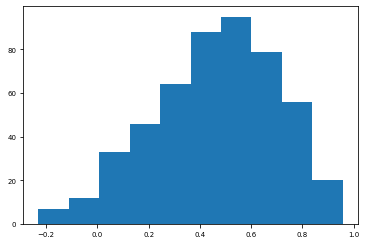

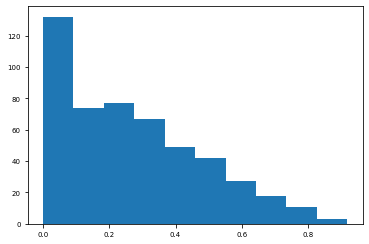

In [23]:
bootnum = 500
np.random.seed(56642)

good = np.isfinite(SMBb.middle_scen) & np.isfinite(KEl_re) #& (SMBb.middle_scen > 10)

SMBr = SMBb.middle_scen[good].data
KEr = KEl_re[good].data

ndat = KEr.size
idxs = np.arange(ndat)

rvals = np.zeros((bootnum))
pvals = np.zeros((bootnum))

for i in range(bootnum):
    idxs_ = np.random.choice(idxs, ndat)
    rvals[i], pvals[i] = stats.pearsonr(SMBr[idxs_], KEr[idxs_])

fig, ax = plt.subplots()
_ = ax.hist(rvals)

fig, ax = plt.subplots()
_ = ax.hist(rvals**2)

print(f"R mean {rvals.mean()}")
print(f"R std {rvals.std()}")
print(f"R^2 mean {(rvals**2).mean()}")
print(f"R^2 std {(rvals**2).std()}")

Lag correlation

Lag 3 correlation between IW KE and discharge: 0.0641810183537423
Lag 3 correlation between IW KE and discharge: 0.0641810183537423


(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.16033951, 0.2126269 , 0.37871607, 0.49619009, 0.53839944,
        0.60577049, 0.67977185, 0.73659359, 0.82816513, 0.84668015,
        0.92762659, 0.85536965, 0.8008808 , 0.74456454, 0.69549225,
        0.62943733, 0.53996765, 0.41814066, 0.35096044, 0.28272317,
        0.21188819]),
 <matplotlib.lines.Line2D at 0x1313e9b70>)

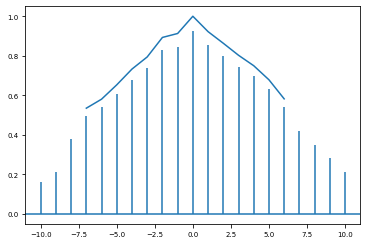

In [24]:
lag = 3
mode = "same"

from scipy.signal import correlate, correlation_lags

out = correlate(SMBb.middle_scen.data, KEb_re.data, mode=mode)
lags = correlation_lags(SMBb.middle_scen.data.size, KEb_re.data.size, mode=mode)

fig, ax = plt.subplots()
ax.plot(lags, out/out[out.size//2])

print(f"Lag {lag} correlation between IW KE and discharge: {xr.corr(SMBb.middle_scen[:-lag], KEb_re[lag:]).data}")
print(f"Lag {lag} correlation between IW KE and discharge: {xr.corr(SMBb.middle_scen[lag:], KEb_re[:-lag]).data}")

# fig, ax = plt.subplots()
ax.xcorr(SMBb.middle_scen.data, KEb_re.data)

## Spectral analysis

In [25]:
dt = (AS.time[1] - AS.time[0]).data.astype("timedelta64[s]").astype(float)
frac_min = 0.9
nhigh = int(60*3/dt)
nlow = int(60*30/dt)
nminhigh = int(frac_min*nhigh)
nminlow = int(frac_min*nlow)
npitch = 7
max_pitch_var = 0.05
dmin = 20
dmax = 120
nhours = 1 # Time binning
min_good = 0.9 # Depth fraction allowed

pitch_var = AS.pitch.rolling(time=npitch, center=True).var()

# Remove iceberg events
bad = pitch_var > max_pitch_var
contig = jsig.contiguous_regions(bad)
idx0 = contig[:, 0]
idx1 = contig[:, 1]
# go 2 min earlier
idx0 -= int(60*2/dt)
# go 20 min later
idx1 = idx0 + int(60*20/dt)

# Make mask
for i in range(idx0.size):
    bad[idx0[i]:idx1[i]] = True
    
good = ~bad

time1 = np.datetime64("2018-09-06T15:00")
tslice = slice(time1, time1 + np.timedelta64(3600*3, 's'))

In [26]:
AS_ = AS.isel(distance=(AS.depth > dmin) & (AS.depth < dmax))

ul = AS_.u.where(good).rolling(time=nlow, min_periods=nminlow, center=True).mean()
uh = AS_.u.where(good).rolling(time=nhigh, min_periods=nminhigh, center=True).mean()
ub = uh - ul
wl = AS_.vv.where(good).rolling(time=nlow, min_periods=nminlow, center=True).mean()
wh = AS_.vv.where(good).rolling(time=nhigh, min_periods=nminhigh, center=True).mean()
wb = wh - wl
vl = AS_.v.where(good).rolling(time=nlow, min_periods=nminlow, center=True).mean()
vh = AS_.v.where(good).rolling(time=nhigh, min_periods=nminhigh, center=True).mean()
vb = vh - vl

KEl = ul**2 + vl**2
KEb = ub**2 + vb**2 + wb**2

Energy in the different frequency bands. 

/var/folders/qm/pnvvmx2d5gd97cbng1gmddzw0000gn/T/ipykernel_13329/40031978.py:19: RuntimeWarning: Mean of empty slice
  logKE_AS = np.log10(np.nanmean(SKE_AS.real, axis=-1).T)
/var/folders/qm/pnvvmx2d5gd97cbng1gmddzw0000gn/T/ipykernel_13329/40031978.py:39: RuntimeWarning: Mean of empty slice
  logKE_AS = np.log10(np.nanmean(SKE_AS.real, axis=-1).T)
/var/folders/qm/pnvvmx2d5gd97cbng1gmddzw0000gn/T/ipykernel_13329/40031978.py:49: RuntimeWarning: Mean of empty slice
  logKE_AS = np.log10(np.nanmean(SKE_AS.real, axis=-1).T)


Text(0, 0.5, 'Spectral density [m$^2$ s$^{-2}$ cpd$^{-1}$]')

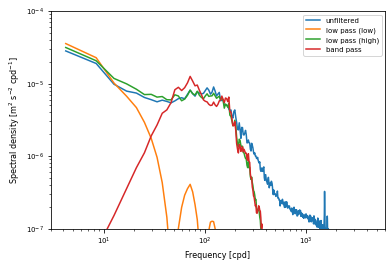

In [27]:
nperseg = 2**11  # 2**9 is about 1.5 hours for a time step of 10 seconds
noverlap = nperseg/2
window = "hann"
fs = 86400./10.  # in cpd
clevs = np.linspace(-7, -4, 7)
scaling = "density"
dmin = 30
dmax = 100.
cmap = "autumn"
padded = False

fig, ax = plt.subplots()
ax.set_ylim(1e-7, 1e-4)

freqs, time, Suu = spectrogram(AS.u, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
freqs, time, Svv = spectrogram(AS.v, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
freqs, time, Sww = spectrogram(AS.vv, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
SKE_AS =  0.5*(Suu + Svv + Sww) # 0.5*Sww
logKE_AS = np.log10(np.nanmean(SKE_AS.real, axis=-1).T)


use = (AS.depth_adcp > dmin) & (AS.depth_adcp < dmax)
ax.loglog(freqs[1:], np.nanmean(10**logKE_AS[use, 1:], axis=0), label="unfiltered")

freqs, time, Suu = spectrogram(ul, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
freqs, time, Svv = spectrogram(vl, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
freqs, time, Sww = spectrogram(wl, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
SKE_AS =  0.5*(Suu + Svv + Sww) # 0.5*Sww
logKE_AS = np.log10(np.nanmean(SKE_AS.real, axis=-1).T)


use = (wl.depth_adcp > dmin) & (wl.depth_adcp < dmax)
ax.loglog(freqs[1:], np.nanmean(10**logKE_AS[use, 1:], axis=0), label="low pass (low)")

freqs, time, Suu = spectrogram(uh, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
freqs, time, Svv = spectrogram(vh, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
freqs, time, Sww = spectrogram(wh, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
SKE_AS =  0.5*(Suu + Svv + Sww) # 0.5*Sww
logKE_AS = np.log10(np.nanmean(SKE_AS.real, axis=-1).T)


use = (wl.depth_adcp > dmin) & (wl.depth_adcp < dmax)
ax.loglog(freqs[1:], np.nanmean(10**logKE_AS[use, 1:], axis=0), label="low pass (high)")

freqs, time, Suu = spectrogram(ub, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
freqs, time, Svv = spectrogram(vb, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
freqs, time, Sww = spectrogram(wb, fs, window=window, nperseg=nperseg, noverlap=noverlap, scaling=scaling, axis=0)
SKE_AS =  0.5*(Suu + Svv + Sww) # 0.5*Sww
logKE_AS = np.log10(np.nanmean(SKE_AS.real, axis=-1).T)


use = (wl.depth_adcp > dmin) & (wl.depth_adcp < dmax)
ax.loglog(freqs[1:], np.nanmean(10**logKE_AS[use, 1:], axis=0), label="band pass")
ax.legend()

ax.set_xlabel("Frequency [cpd]")
ax.set_ylabel("Spectral density [m$^2$ s$^{-2}$ cpd$^{-1}$]")

# MD - downstream mooring

Repeat analysis above for the downstream mooring.

In [28]:
dt = (DD.time[1] - DD.time[0]).data.astype("timedelta64[s]").astype(float)
frac_min = 0.9
nhigh = NFc(60*5, int(dt))
nlow = NFc(60*30, int(dt))
nminhigh = int(frac_min*nhigh)
nminlow = int(frac_min*nlow)
npitch = 7
max_pitch_var = 0.05
dmin = 20
dmax = 120
nhours = 1 # Time binning
min_good = 0.9 # Depth fraction allowed

print(f"High cut off = {Tcmin(10, nhigh):1.2f} min")
print(f"Low cut off = {Tcmin(10, nlow):1.2f} min")
print(f"High cut off = {1440/Tcmin(10, nhigh):1.2f} cpd")
print(f"Low cut off = {1440/Tcmin(10, nlow):1.2f} cpd")
print(f"n High = {nhigh}")
print(f"n Low = {nlow}")

pitch_var = DD.pitch.isel(instrument=1).rolling(time=npitch, center=True).var()

# Remove iceberg events
bad = pitch_var > max_pitch_var
contig = jsig.contiguous_regions(bad)
idx0 = contig[:, 0]
idx1 = contig[:, 1]
# go 2 min earlier
idx0 -= int(60*2/dt)
# go 20 min later
idx1 = idx0 + int(60*20/dt)

# Make mask
for i in range(idx0.size):
    bad[idx0[i]:idx1[i]] = True
    
good = ~bad

time1 = np.datetime64("2018-09-06T15:00")
tslice = slice(time1, time1 + np.timedelta64(3600*3, 's'))



High cut off = 4.88 min
Low cut off = 30.10 min
High cut off = 295.26 cpd
Low cut off = 47.84 cpd
n High = 13
n Low = 80


In [29]:
DD_ = DD.isel(depth_adcp=(DD.depth_adcp > dmin) & (DD.depth_adcp < dmax))

ul = DD_.u.where(good).rolling(time=nlow, min_periods=nminlow, center=True).mean()
uh = DD_.u.where(good).rolling(time=nhigh, min_periods=nminhigh, center=True).mean()
ub = uh - ul
wl = DD_.w.where(good).rolling(time=nlow, min_periods=nminlow, center=True).mean()
wh = DD_.w.where(good).rolling(time=nhigh, min_periods=nminhigh, center=True).mean()
wb = wh - wl
vl = DD_.v.where(good).rolling(time=nlow, min_periods=nminlow, center=True).mean()
vh = DD_.v.where(good).rolling(time=nhigh, min_periods=nminhigh, center=True).mean()
vb = vh - vl

KEl = ul**2 + vl**2
KEb = ub**2 + vb**2 + wb**2

In [30]:
wb.to_netcdf("../data/MD_band_pass_w.nc")

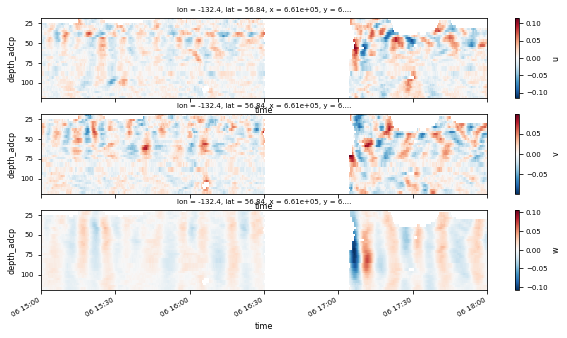

In [31]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 5))

ub.sel(time=tslice).plot(ax=axs[0], x="time", y="depth_adcp", yincrease=False)
vb.sel(time=tslice).plot(ax=axs[1], x="time", y="depth_adcp", yincrease=False)
wb.sel(time=tslice).plot(ax=axs[2], x="time", y="depth_adcp", yincrease=False)

KE low mean 3.83e-03 J kg-1
KE wave mean 9.27e-04 J kg-1
KE std mean 2.70e-05 J kg-1
KE frac mean 19.50%
KE frac std 0.73%
KE frac 90% error 1.47%


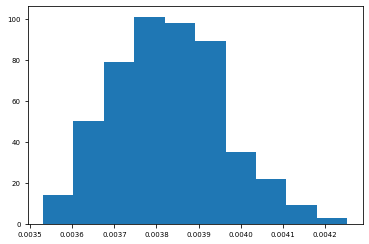

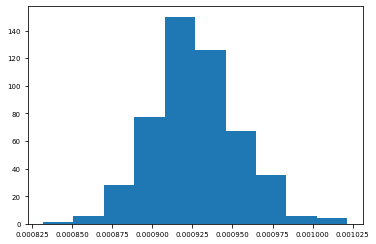

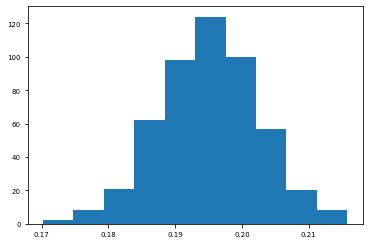

In [32]:
bootnum = 500
np.random.seed(482990)

nall = KEl.isnull() | KEb.isnull()

nmax = nall.distance.size
ngood = nmax - nall.sum("depth_adcp")
frac_good = ngood/nmax
good = (frac_good > min_good)
# dz = (AS.distance[1] - AS.distance[0]).data

KEl_ave = (KEl.sum("depth_adcp")/ngood).where(good)
KEb_ave = (KEb.sum("depth_adcp")/ngood).where(good)

KEl_re = KEl_ave.resample(time=f"{nhours}H", skipna=True).mean()
KEb_re = KEb_ave.resample(time=f"{nhours}H", skipna=True).mean()

good = np.isfinite(KEl_re) & np.isfinite(KEb_re) #& (SMBb.middle_scen > 10)

KElr = KEl_re[good].data
KEbr = KEb_re[good].data

ndat = KEbr.size
idxs = np.arange(ndat)

KEl_mean = np.zeros((bootnum))
KEb_mean = np.zeros((bootnum))

for i in range(bootnum):
    idxs_ = np.random.choice(idxs, ndat)
    KEl_mean[i] = KElr[idxs_].mean()
    KEb_mean[i] = KEbr[idxs_].mean()
    
KE_frac = KEb_mean/(KEb_mean + KEl_mean)

fig, ax = plt.subplots()
_ = ax.hist(KEl_mean)

fig, ax = plt.subplots()
_ = ax.hist(KEb_mean)

fig, ax = plt.subplots()
_ = ax.hist(KE_frac)

print(f"KE low mean {KEl_mean.mean():.2e} J kg-1")
print(f"KE wave mean {KEb_mean.mean():.2e} J kg-1")
print(f"KE std mean {KEb_mean.std():.2e} J kg-1")
print(f"KE frac mean {KE_frac.mean():.2%}")
print(f"KE frac std {KE_frac.std():.2%}")
print(f"KE frac 90% error {2*KE_frac.std():.2%}")